In [107]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Lambda
import torchinfo
import pickle
from sklearn.metrics import roc_auc_score, roc_curve

import numpy as np
import math
import time

In [108]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU Device:【{}:{}】".format(device.type, device.index))
    torch.cuda.set_device(0)

GPU Device:【cuda:None】


In [109]:
class CustomDataset(Dataset):
    def __init__(self, data:np.ndarray, labels:np.ndarray, transform=ToTensor(), 
    target_transform=Lambda(lambda y: torch.zeros(2, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))):
        self.data:torch.Tensor = torch.from_numpy(data)
        # self.data:torch.Tensor = torch.from_numpy(np.swapaxes(data, 1, 2))
        self.labels:torch.Tensor = torch.from_numpy(labels)
        self.transform = None
        self.target_transform = None
        # self.transform = transform
        # self.target_transform = target_transform
        # self.shuffle()
    
    def shuffle(self, seed=None):
        '\n        seed(self, seed=None)\n\n        Reseed a legacy MT19937 BitGenerator\n        '
        self.shuffle_seed = np.random.randint(1, 65535) if seed is None else seed
        print(f"随机种子：{self.shuffle_seed}")
        np.random.seed(self.shuffle_seed)
        np.random.shuffle(self.data)
        np.random.seed(self.shuffle_seed)
        np.random.shuffle(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx, 0]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

In [110]:
def load_dataset(path="dataset.npz", train_percent=0.8) -> tuple:
    with np.load(path) as dataset:
        full_data = dataset["data"].astype(np.float32)
        full_labels = dataset["labels"].astype(np.int64)
    train_size = int(full_data.shape[0]*train_percent)
    test_size = full_data.shape[0]-train_size
    seed = np.random.randint(1, 65535) # 35468
    np.random.seed(seed)
    np.random.shuffle(full_data)
    np.random.seed(seed)
    np.random.shuffle(full_labels)
    train_data, test_data = full_data[:train_size], full_data[train_size:]
    train_labels, test_labels = full_labels[:train_size], full_labels[train_size:]
    print(f"训练集大小：{train_size}", f"测试集大小：{test_size}", f"随机种子：{seed}")
    train_dataset = CustomDataset(train_data, train_labels)
    test_dataset = CustomDataset(test_data, test_labels)
    return train_dataset, test_dataset

In [111]:
train_dataset, test_dataset = load_dataset("D:\\datasets\\ABIDE\\ABIDE_augmented_dataset.npz", 0.8)

训练集大小：9636 测试集大小：2409 随机种子：3428


In [112]:
batch_size=64

# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
    data_shape = X.shape
    label_shape = y.shape
    print(f"Shape of X [N, L, H]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, L, H]: torch.Size([64, 60, 116])
Shape of y: torch.Size([64]) torch.int64


In [113]:
class DWConv(nn.Module):
    def __init__(self, dim:int):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv1d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x):
        x = self.dwconv(x)
        return x

In [114]:
class LKA(nn.Module):
    def __init__(self, dim:int):
        super().__init__()
        self.conv0 = nn.Conv1d(dim, dim, 5, padding=2, groups=dim)
        self.conv_spatial = nn.Conv1d(dim, dim, 7, stride=1, padding=9, dilation=3, groups=dim)
        self.conv1 = nn.Conv1d(dim, dim, 3, padding=1)
        self.return_attn=False

    def forward(self, x, return_attn=False):
        u = x.clone()
        attn = self.conv0(x)
        attn = self.conv_spatial(attn)
        attn = self.conv1(attn)
        if return_attn:
            return u * attn, attn
        else:
            return u * attn

In [115]:
class ResBlock(nn.Module):

    def __init__(self, out_channels:int=None, device=None, *args, **wargs):
        super().__init__(*args, **wargs)
        self.__built = False
        self.out_channels = out_channels
        self.device = device
        self.return_attn=False

    def build(self, input_shape):
        self.input_shape = input_shape
        in_L, in_H = input_shape[1], input_shape[2]
        out_channels = in_L if self.out_channels is None else in_L
        # resolve output shape in model summary
        # self.lstm = nn.LSTM(in_H, in_H, 1, batch_first=True)
        # self.conv1 = nn.Conv1d(in_L, in_L, 5, padding=2, groups=in_L)
        self.conv2 = nn.Conv1d(in_H, in_H, 3, padding=1)
        self.lka = LKA(in_H)
        self.activation = nn.ReLU()
        self.bn = nn.BatchNorm1d(in_L)
        self.downconv = DWConv(in_L)
        self.output_shape = input_shape
        self.__built = True
        self.to(self.device)

    def forward(self, x:np.ndarray, return_attn=False):
        fx:np.ndarray = x
        # fx, (h_n, c_n) = self.lstm(fx)
        # fx = self.conv1(fx)
        fx = fx.swapaxes(1, 2)
        fx = self.conv2(fx)
        fx, attn = self.lka(fx, True)
        fx = fx.swapaxes(1, 2)
        fx = self.bn(fx)
        if fx.shape[-1] != x.shape[-1]:
            x = self.downconv(x)
        if return_attn:
            return fx + x, attn
        else:
            return fx + x

    def freeze(self):
        for param in self.parameters():
            param.requires_grad = False

In [116]:
class LKAResNet(nn.Module):
    def __init__(self, device=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__built:bool = False
        self.device:torch.DeviceObjType = device
    
    def build(self, input_shape):
        self.lstm = nn.LSTM(116, 116, 2, batch_first=True)
        # An ordinary ResNet, but put blocks in a list. New blocks will be added into this list when training.
        # 常规的残差网络，但将残差块放在一个list中，训练时会将新块添加到这里
        self.blocks:nn.ModuleList = nn.ModuleList([ResBlock() for _ in range(4)])
        for block in self.blocks:
            block.build(input_shape)
            block.to(self.device)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(np.prod(input_shape[1:]), 2)
        self.__built = True

    def compile(self, dataloader:DataLoader, loss_fn, optimizer, lr=1e-2):
        self.batch_size:int = dataloader.batch_size
        for X, y in dataloader:
            self.input_shape:tuple = X.shape
            self.output_shape:tuple = y.shape
            break
        self.build(self.input_shape)
        self.loss_fn = loss_fn()
        self.optimizer = optimizer(filter(lambda p: p.requires_grad, self.parameters()), lr=lr)
        self.to(self.device)
    
    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        x, (h_n, c_n) = self.lstm(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

    def get_attn(self, x):
        self.eval()
        attention = []
        with torch.no_grad():
            for blk in self.blocks:
                x, attn = blk(x, True)
                attention.append(attn.cpu().numpy())
        return np.array(attention)

    def fit(self, dataloader:DataLoader, epochs:int=1, test_dataloader=None):
        size = len(dataloader.dataset)
        num_batches = size // self.batch_size
        time_collection = []
        loss_collection = []
        correct_collection = []
        for epoch in range(epochs):
            print(f"Epoch: {epoch+1}/{epochs}")
            self.train()
            loss, correct = 0, 0
            time_delta = 0
            for batch, (X, y) in enumerate(dataloader):
                X = X.to(self.device)
                y = y.to(self.device)

                # 计时
                torch.cuda.synchronize()
                time_start = time.time()

                # Compute prediction error
                pred = self.forward(X)
                batch_loss = self.loss_fn(pred, y)

                # Backpropagation
                batch_loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                # 计时结束
                torch.cuda.synchronize()
                time_end = time.time()

                current = batch * self.batch_size + len(X)

                batch_loss = batch_loss.item()
                loss += batch_loss

                batch_correct = (pred.argmax(1) == y).type(torch.float).sum().item()
                correct += batch_correct
                batch_correct /= len(X)

                batch_time = time_end - time_start
                time_delta += batch_time
                print(f"\r{batch+1}/{num_batches+1}  [{current:>3d}/{size:>3d}] - batch loss: {batch_loss:>7f} - batch accuracy: {(100*batch_correct):>0.1f}% - {batch_time*1000:>0.3f}ms", end = "", flush=True)
            loss /= num_batches
            correct /= size
            print(f"\n-- Average loss: {loss:>7f} - Accuracy: {(100*correct):>0.1f}% - {time_delta/num_batches*1000:>0.3f}ms/batch")
            time_collection.append(time_delta)
            loss_collection.append(loss)
            correct_collection.append(correct)
            if test_dataloader is not None:
                self.test(test_dataloader)
        print("\n", torchinfo.summary(self, input_size=self.input_shape))
        return correct_collection, loss_collection, time_collection

    def test(self, dataloader:DataLoader, return_preds=False):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        ys = []
        preds = []
        self.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                pred = self.forward(X)
                test_loss += self.loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                if return_preds:
                    ys = np.hstack((ys, y.cpu()))
                    preds = np.hstack((preds, pred.argmax(1).cpu()))
        test_loss /= num_batches
        correct /= size
        print(f"Test Accuracy: {(100*correct):>0.1f}%, Average loss: {test_loss:>8f} \n")
        if return_preds:
            return ys, preds

In [117]:
class MyResNet(nn.Module):
    def __init__(self, device=None, copy_block=False, cache=False, freeze_block=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__blocks_num:int = 1
        self.__frozen_blocks_num:int = 0
        self.__built:bool = False
        self.cache:bool = cache
        self.__cache:list[torch.TensorType] = []
        self.device:torch.DeviceObjType = device
        self.copy_block:bool = copy_block
        self.freeze_block= freeze_block
        if self.cache:
            self.freeze_block = True
    
    def build(self, input_shape):
        # An ordinary ResNet, but put blocks in a list. New blocks will be added into this list when training.
        # 常规的残差网络，但将残差块放在一个list中，训练时会将新块添加到这里
        self.lstm = nn.LSTM(116, 116, 2, batch_first=True)
        self.blocks:nn.ModuleList = nn.ModuleList([ResBlock()])
        # self.blocks1:nn.ModuleList = nn.ModuleList([ResBlock(1)])
        for block in self.blocks:
            block.build(input_shape)
            block.to(self.device)
        # for block in self.blocks1:
        #     block.build(input_shape)
        #     block.to(self.device)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(np.prod(input_shape[1:]), 2)
        self.__built = True

    def compile(self, dataloader:DataLoader, loss_fn, optimizer, lr=1e-2):
        self.batch_size:int = dataloader.batch_size
        for X, y in dataloader:
            self.input_shape:tuple = X.shape
            self.output_shape:tuple = y.shape
            break
        self.build(self.input_shape)
        self.loss_fn = loss_fn()
        self.optimizer = optimizer(filter(lambda p: p.requires_grad, self.parameters()), lr=lr)
        self.to(self.device)
    
    def forward(self, x):
        if self.cache:
            for i in range(self.__frozen_blocks_num, self.__blocks_num):
                x = self.blocks[i](x)
        else:
            for i in range(self.__blocks_num):
                x = self.blocks[i](x)
        x, (h_n, c_n) = self.lstm(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

    def getBlocksNum(self):
        return self.__blocks_num
    
    def freeze(self, block:ResBlock):
        if self.freeze_block:
            for param in block.parameters():
                param.requires_grad = False
    
    def __forward_cache(self, block):
        if self.cache:
            with torch.no_grad():
                for batch, X in enumerate(self.__cache):
                    self.__cache[batch] = block(X.to(self.device))

    def addNewBlock(self, copy_last=False):
        print("----------")
        print(f"{'Copying' if copy_last else 'Adding'} new block...")
        newBlock = ResBlock()
        last_block:ResBlock = self.blocks[-1]
        newBlock.build(last_block.output_shape)
        if copy_last:
            # 复制上一层参数
            newBlock.load_state_dict(last_block.state_dict())
        self.blocks.append(newBlock)
        newBlock.to(self.device)
        self.__blocks_num += 1
        if self.freeze_block:
            self.freeze(last_block)
        self.__frozen_blocks_num += 1
        self.__forward_cache(last_block)
        print("Success!")

    def get_attn(self, x):
        self.eval()
        attention = []
        with torch.no_grad():
            for blk in self.blocks:
                x, attn = blk(x, True)
                attention.append(attn.cpu().numpy())
        return np.array(attention)

    def add_condition(self, epoch):
        if self.__blocks_num < 4:
            if epoch and epoch%5 == 0:
                return True
        return False

    def fit(self, dataloader:DataLoader, epochs:int=1, test_dataloader=None):
        size = len(dataloader.dataset)
        num_batches = size // self.batch_size
        time_collection = []
        loss_collection = []
        correct_collection = []
        for epoch in range(epochs):
            print(f"Epoch: {epoch+1}/{epochs}")
            self.train()
            if self.add_condition(epoch):
                self.addNewBlock(self.copy_block)
            loss, correct = 0, 0

            time_delta = 0
            for batch, (X, y) in enumerate(dataloader):
                if self.cache:
                    if epoch == 0:
                        self.__cache.append(X)
                    X = self.__cache[batch].to(device)
                else:
                    X = X.to(device)
                y = y.to(device)

                # 计时
                torch.cuda.synchronize()
                time_start = time.time()

                # Compute prediction error
                pred = self.forward(X)
                batch_loss = self.loss_fn(pred, y)

                # Backpropagation
                batch_loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                # 计时结束
                torch.cuda.synchronize()
                time_end = time.time()

                current = batch * self.batch_size + len(X)

                batch_loss = batch_loss.item()
                loss += batch_loss

                batch_correct = (pred.argmax(1) == y).type(torch.float).sum().item()
                correct += batch_correct
                batch_correct /= len(X)

                batch_time = time_end - time_start
                time_delta += batch_time
                print(f"\r{batch+1}/{num_batches+1}  [{current:>3d}/{size:>3d}] - batch loss: {batch_loss:>7f} - batch accuracy: {(100*batch_correct):>0.1f}% - {batch_time*1000:>0.3f}ms", end = "", flush=True)
            loss /= num_batches
            correct /= size
            print(f"\n-- Average loss: {loss:>7f} - Accuracy: {(100*correct):>0.1f}% - {time_delta/num_batches*1000:>0.3f}ms/batch")
            time_collection.append(time_delta)
            loss_collection.append(loss)
            correct_collection.append(correct)
            if test_dataloader is not None:
                self.test(test_dataloader)
        print("\n", torchinfo.summary(self, input_size=self.input_shape))
        return correct_collection, loss_collection, time_collection

    def test(self, dataloader:DataLoader, return_preds=False):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        ys = []
        preds = []
        self.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                pred = self.forward(X)
                test_loss += self.loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                if return_preds:
                    ys = np.hstack((ys, y.cpu()))
                    preds = np.hstack((preds, pred.argmax(1).cpu()))
        test_loss /= num_batches
        correct /= size
        print(f"Test Accuracy: {(100*correct):>0.1f}%, Average loss: {test_loss:>8f} \n")
        if return_preds:
            return ys, preds


In [118]:
lr = 5e-5
epochs = 20
loss_fn = nn.CrossEntropyLoss
optimizer = torch.optim.Adam

In [119]:
correct, loss, timing = {}, {}, {}

In [120]:
base_model = LKAResNet(device)
base_model.compile(train_dataloader, loss_fn=loss_fn, optimizer=optimizer, lr=lr)
correct["RLKA"], loss["RLKA"], timing["RLKA"] = base_model.fit(train_dataloader, epochs=epochs, test_dataloader=test_dataloader)

Epoch: 1/20
151/151  [9636/9636] - batch loss: 0.682352 - batch accuracy: 55.6% - 23.996ms
-- Average loss: 0.694458 - Accuracy: 53.5% - 27.258ms/batch
Test Accuracy: 53.7%, Average loss: 0.689475 

Epoch: 2/20
151/151  [9636/9636] - batch loss: 0.631272 - batch accuracy: 58.3% - 24.997ms
-- Average loss: 0.684957 - Accuracy: 54.8% - 24.997ms/batch
Test Accuracy: 55.3%, Average loss: 0.683863 

Epoch: 3/20
151/151  [9636/9636] - batch loss: 0.520959 - batch accuracy: 88.9% - 22.999ms
-- Average loss: 0.663538 - Accuracy: 58.9% - 24.901ms/batch
Test Accuracy: 59.9%, Average loss: 0.659424 

Epoch: 4/20
151/151  [9636/9636] - batch loss: 0.339079 - batch accuracy: 80.6% - 23.302ms
-- Average loss: 0.592180 - Accuracy: 68.2% - 23.311ms/batch
Test Accuracy: 68.4%, Average loss: 0.582306 

Epoch: 5/20
151/151  [9636/9636] - batch loss: 0.213422 - batch accuracy: 94.4% - 20.000ms
-- Average loss: 0.493599 - Accuracy: 74.2% - 23.435ms/batch
Test Accuracy: 72.9%, Average loss: 0.513742 

Epoch

In [121]:
model = MyResNet(device)
model.compile(train_dataloader, loss_fn=loss_fn, optimizer=optimizer, lr=lr)
correct["VRLKA"], loss["VRLKA"], timing["VRLKA"] = model.fit(train_dataloader, epochs=epochs, test_dataloader=test_dataloader)

Epoch: 1/20
151/151  [9636/9636] - batch loss: 0.677110 - batch accuracy: 55.6% - 10.998ms
-- Average loss: 0.694582 - Accuracy: 53.5% - 13.369ms/batch
Test Accuracy: 53.8%, Average loss: 0.689167 

Epoch: 2/20
151/151  [9636/9636] - batch loss: 0.648693 - batch accuracy: 58.3% - 10.995ms
-- Average loss: 0.686317 - Accuracy: 54.8% - 13.836ms/batch
Test Accuracy: 55.2%, Average loss: 0.683784 

Epoch: 3/20
151/151  [9636/9636] - batch loss: 0.581384 - batch accuracy: 86.1% - 12.998ms
-- Average loss: 0.668082 - Accuracy: 58.5% - 13.916ms/batch
Test Accuracy: 59.6%, Average loss: 0.662055 

Epoch: 4/20
151/151  [9636/9636] - batch loss: 0.456095 - batch accuracy: 69.4% - 12.000ms
-- Average loss: 0.603899 - Accuracy: 67.6% - 13.640ms/batch
Test Accuracy: 68.0%, Average loss: 0.581988 

Epoch: 5/20
151/151  [9636/9636] - batch loss: 0.356873 - batch accuracy: 86.1% - 12.622ms
-- Average loss: 0.500312 - Accuracy: 74.1% - 13.188ms/batch
Test Accuracy: 73.4%, Average loss: 0.506259 

Epoch

In [122]:
freeze_model = MyResNet(device, freeze_block=True)
freeze_model.compile(train_dataloader, loss_fn=loss_fn, optimizer=optimizer, lr=lr)
correct["freeze_parameters"], loss["freeze_parameters"], timing["freeze_parameters"] = freeze_model.fit(train_dataloader, epochs=epochs, test_dataloader=test_dataloader)

Epoch: 1/20
151/151  [9636/9636] - batch loss: 0.688760 - batch accuracy: 55.6% - 11.891ms
-- Average loss: 0.695681 - Accuracy: 53.6% - 13.463ms/batch
Test Accuracy: 53.8%, Average loss: 0.689597 

Epoch: 2/20
151/151  [9636/9636] - batch loss: 0.671565 - batch accuracy: 58.3% - 12.000ms
-- Average loss: 0.690165 - Accuracy: 54.6% - 13.604ms/batch
Test Accuracy: 54.0%, Average loss: 0.687181 

Epoch: 3/20
151/151  [9636/9636] - batch loss: 0.633426 - batch accuracy: 58.3% - 12.001ms
-- Average loss: 0.680419 - Accuracy: 56.0% - 13.582ms/batch
Test Accuracy: 57.9%, Average loss: 0.676810 

Epoch: 4/20
151/151  [9636/9636] - batch loss: 0.514141 - batch accuracy: 75.0% - 10.998ms
-- Average loss: 0.646910 - Accuracy: 62.6% - 13.980ms/batch
Test Accuracy: 66.5%, Average loss: 0.620674 

Epoch: 5/20
151/151  [9636/9636] - batch loss: 0.350823 - batch accuracy: 88.9% - 10.996ms
-- Average loss: 0.543711 - Accuracy: 71.6% - 13.136ms/batch
Test Accuracy: 71.9%, Average loss: 0.525633 

Epoch

In [123]:
copy_model = MyResNet(device, copy_block=True, freeze_block=True)
copy_model.compile(train_dataloader, loss_fn=loss_fn, optimizer=optimizer, lr=lr)
correct["copy_parameters"], loss["copy_parameters"], timing["copy_parameters"] = copy_model.fit(train_dataloader, epochs=epochs, test_dataloader=test_dataloader)

Epoch: 1/20
151/151  [9636/9636] - batch loss: 0.680181 - batch accuracy: 55.6% - 11.999ms
-- Average loss: 0.694428 - Accuracy: 54.1% - 13.287ms/batch
Test Accuracy: 53.8%, Average loss: 0.688957 

Epoch: 2/20
151/151  [9636/9636] - batch loss: 0.650388 - batch accuracy: 55.6% - 11.999ms
-- Average loss: 0.687619 - Accuracy: 54.6% - 13.541ms/batch
Test Accuracy: 54.4%, Average loss: 0.684827 

Epoch: 3/20
151/151  [9636/9636] - batch loss: 0.576666 - batch accuracy: 80.6% - 12.000ms
-- Average loss: 0.672147 - Accuracy: 56.9% - 13.844ms/batch
Test Accuracy: 57.3%, Average loss: 0.666260 

Epoch: 4/20
151/151  [9636/9636] - batch loss: 0.391644 - batch accuracy: 72.2% - 10.999ms
-- Average loss: 0.609287 - Accuracy: 67.4% - 13.563ms/batch
Test Accuracy: 68.9%, Average loss: 0.576781 

Epoch: 5/20
151/151  [9636/9636] - batch loss: 0.261017 - batch accuracy: 94.4% - 11.998ms
-- Average loss: 0.492641 - Accuracy: 74.8% - 13.257ms/batch
Test Accuracy: 74.4%, Average loss: 0.500615 

Epoch

In [124]:
cache_model = MyResNet(device, cache=True, freeze_block=True)
cache_model.compile(train_dataloader, loss_fn=loss_fn, optimizer=optimizer, lr=lr)
correct["use_cache"], loss["use_cache"], timing["use_cache"] = cache_model.fit(train_dataloader, epochs=epochs, test_dataloader=test_dataloader)

Epoch: 1/20
151/151  [9636/9636] - batch loss: 0.678668 - batch accuracy: 55.6% - 10.998ms
-- Average loss: 0.694778 - Accuracy: 53.7% - 13.700ms/batch
Test Accuracy: 53.7%, Average loss: 0.689024 

Epoch: 2/20
151/151  [9636/9636] - batch loss: 0.655984 - batch accuracy: 58.3% - 11.999ms
-- Average loss: 0.688023 - Accuracy: 54.6% - 13.738ms/batch
Test Accuracy: 54.0%, Average loss: 0.684892 

Epoch: 3/20
151/151  [9636/9636] - batch loss: 0.600847 - batch accuracy: 86.1% - 10.998ms
-- Average loss: 0.672667 - Accuracy: 57.4% - 13.760ms/batch
Test Accuracy: 58.2%, Average loss: 0.665739 

Epoch: 4/20
151/151  [9636/9636] - batch loss: 0.451293 - batch accuracy: 69.4% - 9.999mss
-- Average loss: 0.609087 - Accuracy: 66.3% - 13.508ms/batch
Test Accuracy: 67.7%, Average loss: 0.574772 

Epoch: 5/20
151/151  [9636/9636] - batch loss: 0.309991 - batch accuracy: 72.2% - 9.998mss
-- Average loss: 0.492709 - Accuracy: 74.1% - 13.347ms/batch
Test Accuracy: 74.0%, Average loss: 0.500661 

Epoch

In [127]:
torch.save(base_model, "model/base_model.pth")
torch.save(model, "model/model.pth")
torch.save(freeze_model, "model/freeze_model.pth")
torch.save(cache_model, "model/cache_model.pth")
torch.save(copy_model, "model/copy_model.pth")

In [128]:
with open("fitting_res.pkl", "wb") as f:
    pickle.dump({
        "correct" : correct, 
        "loss"    : loss, 
        "timing"  : timing
    }, f)

In [129]:
for x, y in test_dataloader:
    attn = base_model.get_attn(x.to(device))
    with open("attention/base_model.pkl", "wb") as f:
        pickle.dump(attn, f)
    attn = model.get_attn(x.to(device))
    with open("attention/model.pkl", "wb") as f:
        pickle.dump(attn, f)
    attn = freeze_model.get_attn(x.to(device))
    with open("attention/freeze_model.pkl", "wb") as f:
        pickle.dump(attn, f)
    attn = copy_model.get_attn(x.to(device))
    with open("attention/copy_model.pkl", "wb") as f:
        pickle.dump(attn, f)
    attn = cache_model.get_attn(x.to(device))
    with open("attention/cache_model.pkl", "wb") as f:
        pickle.dump(attn, f)
    break

In [1]:
import pickle
with open("fitting_res.pkl", "rb") as f:
    tmp = pickle.load(f)
correct, loss, timing = tmp["correct"], tmp["loss"], tmp["timing"]
epochs = 20

In [3]:
import matplotlib.pyplot as plt
import os

plt.rcParams['font.family']=['Times New Roman']
fontsize = 18
plt.rcParams['font.size']=fontsize
plt.rcParams['xtick.labelsize']=fontsize
plt.rcParams['ytick.labelsize']=fontsize
plt.rcParams['axes.labelsize']=fontsize
bg_color = None
fig_format = "jpg"
fig_dir = "./figs/results"
os.makedirs(fig_dir, exist_ok=True)

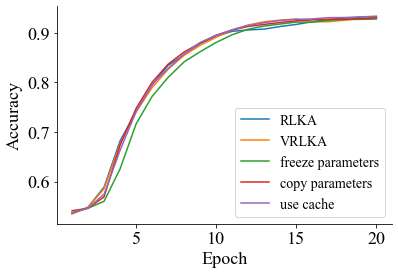

In [27]:
fig, ax = plt.subplots()

x = list(range(1, epochs+1))
for key in correct:
    ax.plot(x, correct[key], label=key.replace("_", " "))
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

ax.legend(loc='best', prop = {'size':14}, ncol=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(f"{fig_dir}/Accuracy.{fig_format}", dpi=300, format=fig_format, bbox_inches = "tight")

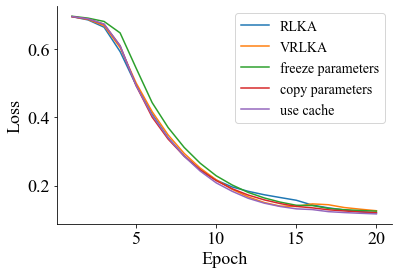

In [26]:
fig, ax = plt.subplots()

x = list(range(1, epochs+1))
for key in loss:
    ax.plot(x, loss[key], label=key.replace("_", " "))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

ax.legend(loc='best', prop = {'size':14}, ncol=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(f"{fig_dir}/Loss.{fig_format}", dpi=300, format=fig_format, bbox_inches = "tight")

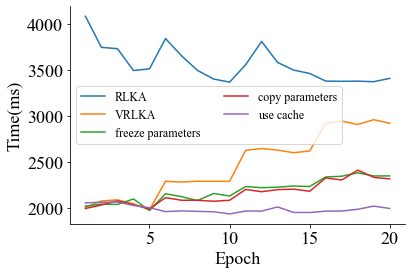

In [25]:
fig, ax = plt.subplots()

x = list(range(1, epochs+1))
for key in timing:
    y = [t*1000 for t in timing[key]]
    ax.plot(x, y, label=key.replace("_", " "))
ax.set_xlabel("Epoch")
ax.set_ylabel("Time(ms)")
# ax.set_ylim(top=5000)

ax.legend(loc='best', prop = {'size':12}, ncol=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(f"{fig_dir}/Time.{fig_format}", dpi=300, format=fig_format, bbox_inches = "tight")

In [136]:
def test(self, dataloader:DataLoader, return_preds=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    if return_preds:
        ys = []
        preds = []
    self.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = self.forward(X)
            test_loss += self.loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if return_preds:
                ys = np.hstack((ys, y.cpu()))
                preds = np.hstack((preds, pred[...,1].cpu()))
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return ys, preds

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.288709 

Test Error: 
 Accuracy: 89.2%, Avg loss: 0.288101 

Test Error: 
 Accuracy: 89.8%, Avg loss: 0.232262 

Test Error: 
 Accuracy: 88.9%, Avg loss: 0.304003 

Test Error: 
 Accuracy: 89.2%, Avg loss: 0.251802 



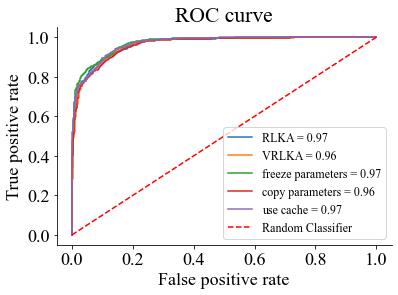

In [137]:
fig, ax = plt.subplots()

ys, preds = test(base_model, test_dataloader, True)
fpr, tpr, thresholds = roc_curve(ys, preds)
auc_score = roc_auc_score(ys, preds)
ax.plot(fpr, tpr, label=f'RLKA = {auc_score:.2f}')

ys, preds = test(model, test_dataloader, True)
fpr, tpr, thresholds = roc_curve(ys, preds)
auc_score = roc_auc_score(ys, preds)
ax.plot(fpr, tpr, label=f'VRLKA = {auc_score:.2f}')

ys, preds = test(freeze_model, test_dataloader, True)
fpr, tpr, thresholds = roc_curve(ys, preds)
auc_score = roc_auc_score(ys, preds)
ax.plot(fpr, tpr, label=f'freeze parameters = {auc_score:.2f}')

ys, preds = test(copy_model, test_dataloader, True)
fpr, tpr, thresholds = roc_curve(ys, preds)
auc_score = roc_auc_score(ys, preds)
ax.plot(fpr, tpr, label=f'copy parameters = {auc_score:.2f}')

ys, preds = test(cache_model, test_dataloader, True)
fpr, tpr, thresholds = roc_curve(ys, preds)
auc_score = roc_auc_score(ys, preds)
ax.plot(fpr, tpr, label=f'use cache = {auc_score:.2f}')

ax.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Classifier')  # 绘制随机分类器的ROC曲线
ax.set_xlabel('False positive rate')  # x轴标签为FPR
ax.set_ylabel('True positive rate')   # y轴标签为TPR
ax.set_title('ROC curve')             # 设置标题
ax.legend(loc='lower right', prop = {'size':12}, ncol=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(f"{fig_dir}/ROC.{fig_format}", dpi=300, format=fig_format, bbox_inches = "tight")